# Import Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


data_out_df = pd.read_csv('digital_output_static_test.csv')
input_df = pd.read_csv('input_voltage_static_test.csvs')

t = input_df['time (s)'].tolist()
vin = input_df['VT("/vin") (V)'].tolist()

print(t)

[0.0, 5.288e-08, 1.586e-07, 3.702e-07, 6.851e-07, 1e-06, 1e-06, 1e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.001e-06, 1.002e-06, 1.002e-06, 1.003e-06, 1.006e-06, 1.009e-06, 1.013e-06, 1.014e-06, 1.017e-06, 1.018e-06, 1.021e-06, 1.022e-06, 1.025e-06, 1.03e-06, 1.041e-06, 1.046e-06, 1.056e-06, 1.077e-06, 1.1e-06, 1.1e-06, 1.1e-06, 1.1e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.101e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.102e-06, 1.103e-06, 1.103e-06, 1.103e-06, 1.103e-06, 1.103e-06, 1.104e-06, 1.104e-06, 1.104e-06, 1.104e-06, 1.105e-06, 1.105e-06, 1.105e-06, 1.1

In [1610]:
start_t = t.index(1.17e-6)
end_t = t.index(52.88e-6)

t = t[start_t:end_t]
vin = vin[start_t:end_t]

dout = []

for i in range(0, 8):
    dout.append(data_out_df[f'VT("/data<0:7>") bit /data<{i}>  (V)'].tolist())
    dout[i] = dout[i][start_t:end_t]

# Generate Code Transition Levels

### Scale each bit

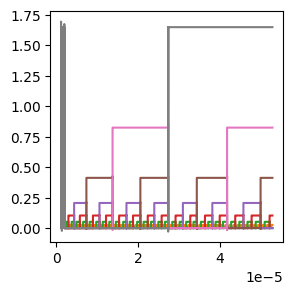

In [1611]:
scaled_dout = []

for n, bit in enumerate(dout):
    scaled_dout.append(np.array([point * ((2**n)/256) for point in bit]))

plt.figure(figsize=(3, 3))
for s in scaled_dout:
    plt.plot(t, s)

### Sum all the bits

In [1612]:
sum = scaled_dout[0] + scaled_dout[1] + scaled_dout[2] + scaled_dout[3] + scaled_dout[4] + scaled_dout[5] + scaled_dout[6] + scaled_dout[7]

adc_code = sum/3.3 * 256  # scale the sum to reference it to the ADC binary codes

# Generate Ideal Code Transition Levels (CTL's)

In [1613]:
# parameters
start_value = 0.0
end_value = 256
num_steps = 256
step_duration = 1 / num_steps
step_size = (end_value - start_value) / num_steps

# Generate step edges
x = np.arange(0, num_steps + 1) * step_duration + 1  # +1 as in your last line
y = np.arange(start_value, end_value + step_size, step_size)

# Generate stair-step vectors
x_ideal = np.repeat(x, 2)[1:-1]
y_ideal = np.repeat(y, 2)[:-2]

Text(0.5, 1.0, "Unfiltered CTL's From Cadence Simulations Compared to Ideal CTL's")

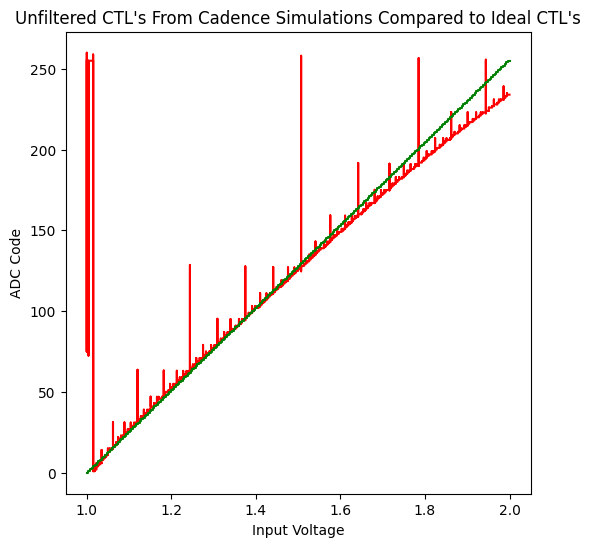

In [1614]:
# ideal CTL's
x_ideal = np.array(x_ideal)
y_ideal = np.array(y_ideal)

# measured CTL's
x_measured = np.array(vin)
y_measured = np.array(adc_code)

plt.figure(figsize=(6, 6))
plt.plot(x_measured, y_measured, 'red')
plt.plot(x_ideal, y_ideal, 'green')
plt.xlabel('Input Voltage')
plt.ylabel('ADC Code')
plt.title('Unfiltered CTL\'s From Cadence Simulations Compared to Ideal CTL\'s')

# Algorithm to get corners of each step

## Also calculating offset error

Text(1.01340625, 29, 'Offset = -2.86 LSB')

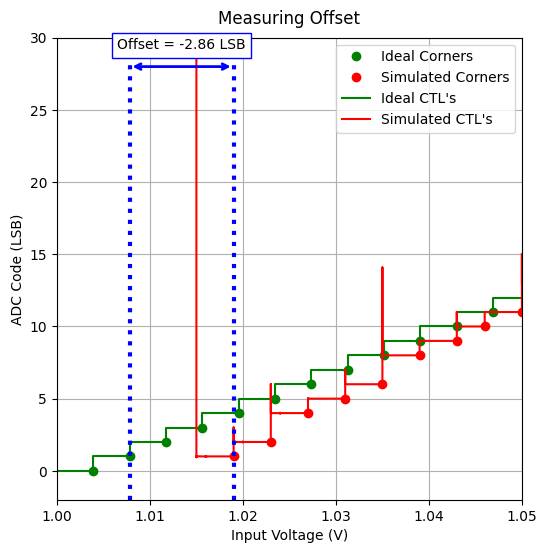

In [1615]:
# Create mask for strictly increasing vin (no duplicates)
mask = np.diff(x_measured) > 1e-12
mask = np.concatenate(([True], mask))  # keep first point

mask2 = np.diff(x_ideal) > 1e-12
mask2 = np.concatenate(([True], mask2))

# Apply mask
x_ideal_clean = x_ideal[mask2] 
y_ideal_clean = y_ideal[mask2]

x_measured_clean = x_measured[mask]
y_measured_clean = y_measured[mask]

# x_adj_clean = offset_adj[mask]

tol = 0.1  # tolerance for code equality

# ----------------------------------------------------------

x_measured_corners = []
y_measured_corners = []

x_ideal_corners = []
y_ideal_corners = []

# analyze each step and filter out the values that don't represent a CTL, like a voltage spike

# simulated signal 
prev_code = None
for i in range(len(y_measured_clean) - 1, -1, -1):
    curr_code = y_measured_clean[i]
    if prev_code is None or abs(curr_code - prev_code) > tol:
        y_measured_corners.append(curr_code)
        x_measured_corners.append(x_measured_clean[i])
        prev_code = curr_code

# ideal signal
prev_code = None
for i in range(len(y_ideal_clean) - 1, -1, -1):
    curr_code = y_ideal_clean[i]
    if prev_code is None or abs(curr_code - prev_code) > tol:
        y_ideal_corners.append(curr_code)
        x_ideal_corners.append(x_ideal_clean[i])
        prev_code = curr_code

# reverse order
x_measured_corners = x_measured_corners[::-1]
y_measured_corners = y_measured_corners[::-1]

x_ideal_corners = x_ideal_corners[::-1] # filtered_x_plot
y_ideal_corners = y_ideal_corners[::-1] # filtered_ideal_codes


# plot
plt.figure(figsize=(6, 6))
plt.plot(x_ideal_corners, y_ideal_corners, 'go', label='Ideal Corners')
plt.plot(x_measured_corners, y_measured_corners, 'ro', label='Simulated Corners')

plt.plot(x_ideal, y_ideal, 'g', label='Ideal CTL\'s')
plt.plot(x_measured, y_measured, 'r', label='Simulated CTL\'s')

plt.xlim(1, 1.05)
# plt.xlim(1, 2)
plt.ylim(-2, 30)
plt.legend()
plt.grid(True)
plt.xlabel('Input Voltage (V)')
plt.ylabel('ADC Code (LSB)')
plt.title('Measuring Offset', pad=10)

plt.axvline(x=x_ideal_corners[1], color='blue', linestyle=':', linewidth=3)
plt.axvline(x=x_measured_corners[3], color='blue', linestyle=':', linewidth=3)

# Calculate horizontal offset
offset = (x_ideal_corners[1] - x_measured_corners[3])
offset_value_LSB = offset * 256
offset_text = f"Offset = {offset_value_LSB:.2f} LSB"

# Arrow between the two vertical lines
arrow_x_start = x_ideal_corners[1]
arrow_x_end = x_measured_corners[3]
arrow_y = 28  # Adjust based on your y-axis range

plt.annotate(
    '', xy=(arrow_x_end, arrow_y), xytext=(arrow_x_start, arrow_y),
    arrowprops=dict(arrowstyle='<->', color='blue', linewidth=2)
)

# Text label
plt.text(
    (arrow_x_start + arrow_x_end) / 2, arrow_y + 1,
    offset_text,
    ha='center', va='bottom', fontsize=10,
    bbox=dict(facecolor='white', edgecolor='blue')
)

# Calculating Gain error

Text(1.9980000000000002, 244.50000000263137, 'Gain = 1.09 LSB')

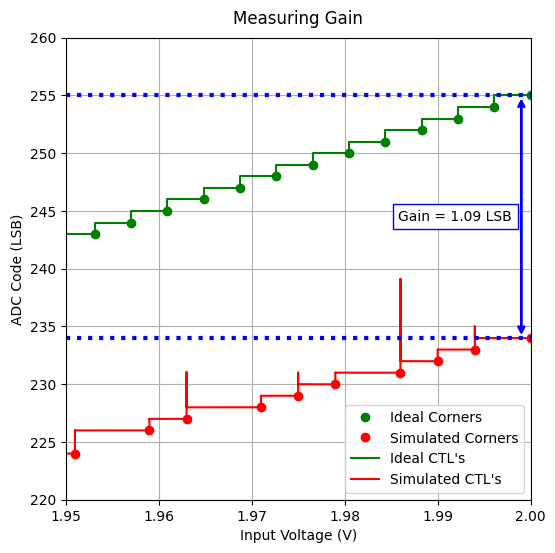

In [1616]:
# calculate gain
gain = (y_ideal_corners[-1] / y_measured_corners[-1])
gain_value_LSB = gain
gain_text = f"Gain = {gain_value_LSB:.2f} LSB"




# --- Arrow coordinates (right side of plot) ---
arrow_x = 1.999  # Adjust to near the right edge of the plot
arrow_y_start = y_measured_corners[-1]
arrow_y_end = y_ideal_corners[-1]

plt.figure(figsize=(6, 6))
plt.plot(x_ideal_corners, y_ideal_corners, 'go', label='Ideal Corners')
plt.plot(x_measured_corners, y_measured_corners, 'ro', label='Simulated Corners')
# plt.plot(filtered_vin, filtered_adj_codes, 'bo', label='GAIN AND OFFSET ADJUSTED corners')

plt.plot(x_ideal, y_ideal, 'g', label='Ideal CTL\'s')
plt.plot(x_measured, y_measured, 'r', label='Simulated CTL\'s')
# plt.plot(vin, offset_adj, 'b', label='GAIN AND OFFSET ADJUSTED corners')

plt.xlim(1.95, 2)
# plt.xlim(1, 2)
plt.ylim(220, 260)
plt.legend()
plt.grid(True)
plt.xlabel('Input Voltage (V)')
plt.ylabel('ADC Code (LSB)')
plt.title('Measuring Gain', pad=10)

plt.axhline(y=y_ideal_corners[-1], color='blue', linestyle=':', linewidth=3)
plt.axhline(y=y_measured_corners[-1], color='blue', linestyle=':', linewidth=3)

# --- Arrow ---
plt.annotate(
    '', xy=(arrow_x, arrow_y_end), xytext=(arrow_x, arrow_y_start),
    arrowprops=dict(arrowstyle='<->', color='blue', linewidth=2)
)

# --- Text label (on the left of the arrow) ---
plt.text(
    arrow_x - 0.001, (arrow_y_start + arrow_y_end) / 2,
    gain_text,
    ha='right', va='center', fontsize=10,
    bbox=dict(facecolor='white', edgecolor='blue')
)

# Apply Offset & Gain

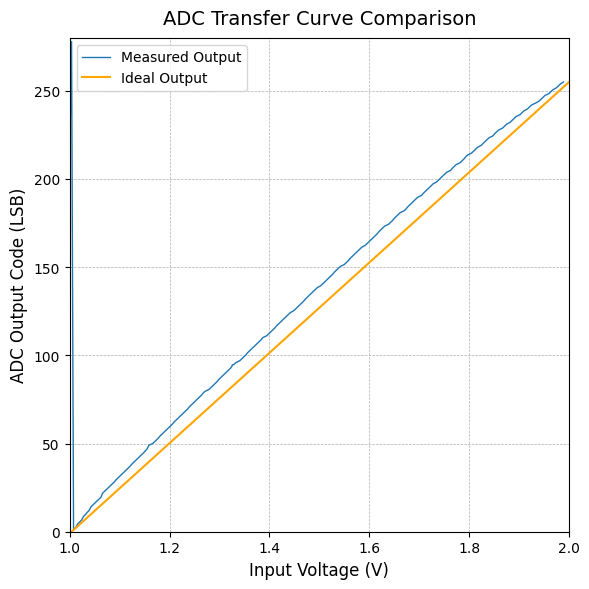

In [1617]:
x_adj = x_measured + offset
y_adj = y_measured * gain

x_adj_clean = x_adj[mask]
y_adj_clean = y_adj[mask]


x_adj_corners = []
y_adj_corners = [] 

prev_code = None
for i in range(len(y_adj_clean) - 1, -1, -1):
    curr_code = y_adj_clean[i]
    if prev_code is None or abs(curr_code - prev_code) > tol:
        y_adj_corners.append(curr_code)
        x_adj_corners.append(x_adj_clean[i])
        prev_code = curr_code


x_adj_corners = x_adj_corners[::-1] # filtered_x_plot
y_adj_corners = y_adj_corners[::-1] # filtered_ideal_codes





plt.figure(figsize=(6, 6))

# Plot your data
plt.plot(x_adj_corners, y_adj_corners, label='Measured Output', linewidth=1)
plt.plot(x_ideal_corners, y_ideal_corners, label='Ideal Output', linewidth=1.5, color='orange')

# Add title and axis labels
plt.title('ADC Transfer Curve Comparison', fontsize=14, pad=10)
plt.xlabel('Input Voltage (V)', fontsize=12)
plt.ylabel('ADC Output Code (LSB)', fontsize=12)

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', fontsize=10)

# Set limits if needed
plt.xlim(1.0, 2.0)
plt.ylim(0, 280)

plt.tight_layout()
plt.show()


# DNL Calculation

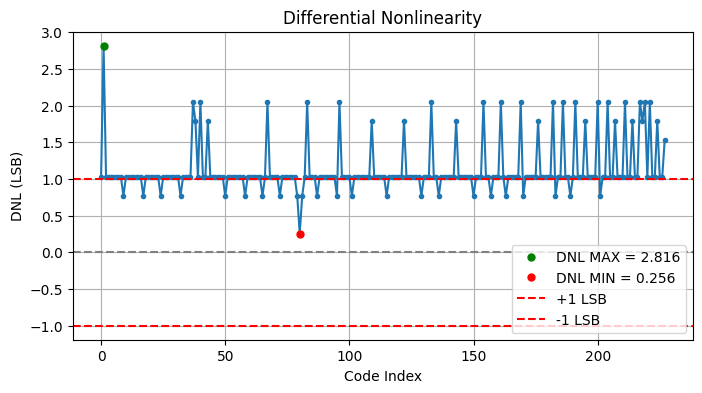

In [1618]:
# Calculate measured step widths (in volts)
delta_vin = np.diff(x_adj_corners)

# Assume ideal LSB size (for example: 1V input range over 256 codes)

# Compute DNL in LSBs
dnl = (delta_vin * 256)
max_dnl = max(dnl)
min_dnl = min(dnl)

# markerline, stemlines, baseline = plt.stem(dnl)

# Set line width for stems and marker size
# plt.setp(stemlines, linewidth=1)
# plt.setp(markerline, markersize=3)
plt.figure(figsize=(8, 4))
plt.plot(dnl, '-o', markersize=3)

# Annotate max and min points
plt.plot(np.where(dnl == max(dnl)), max(dnl), 'go', label=f'DNL MAX = {max_dnl:.3f}', markersize=5)
plt.plot(np.where(dnl == min(dnl)), min(dnl), 'ro', label=f'DNL MIN = {min_dnl:.3f}', markersize=5)

# Reference lines
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(1, color='red', linestyle='--', label='+1 LSB')
plt.axhline(-1, color='red', linestyle='--', label='-1 LSB')

# Labels and grid
plt.xlabel("Code Index")
plt.ylabel("DNL (LSB)")
plt.title("Differential Nonlinearity")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate Midpoints

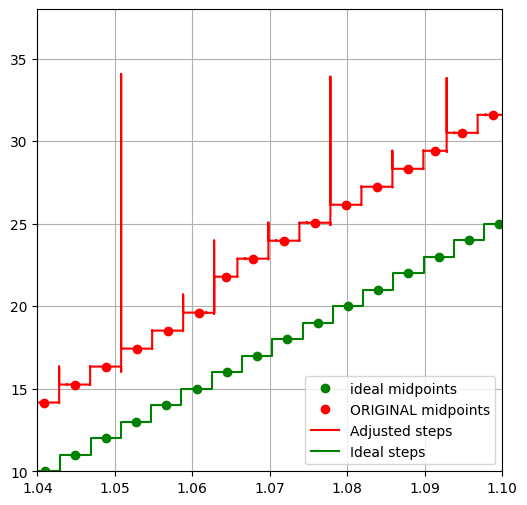

In [1619]:
x_adj_corners = np.array(x_adj_corners)
y_adj_corners = np.array(y_adj_corners)
x_ideal_corners = np.array(x_ideal_corners)
y_ideal_corners = np.array(y_ideal_corners)

x_adj_midpoints = (x_adj_corners[:-1] + x_adj_corners[1:]) / 2
y_adj_midpoints = y_adj_corners[1:]

x_ideal_midpoints = (x_ideal_corners[:-1] + x_ideal_corners[1:]) / 2
y_ideal_midpoints = y_ideal_corners[1:]

# Should match in length and be sorted
assert len(x_ideal_corners) == len(y_ideal_corners)
assert np.all(np.diff(x_ideal_corners) > 0)  # ensure sorted in increasing x

# Only compute midpoints if at least 2 points exist
if len(x_ideal_corners) >= 2:
    midpoints_x_plot = (x_ideal_corners[:-1] + x_ideal_corners[1:]) / 2
    midpoints_ideal = y_ideal_corners[1:]
else:
    x_ideal_midpoints = []
    y_ideal_midpoints = []

plt.figure(figsize=(6, 6))
plt.plot(x_ideal_midpoints, y_ideal_midpoints, 'go', label='ideal midpoints')
plt.plot(x_adj_midpoints, y_adj_midpoints, 'ro', label='ORIGINAL midpoints')
# plt.plot(midpoints_vin, midpoint_adj_codes, 'bo', label='GAIN AND OFFSET ADJUSTED corners')

plt.plot(x_adj, y_adj, 'r', label='Adjusted steps')
plt.plot(x_ideal, y_ideal, 'g', label='Ideal steps')
# plt.plot(vin, offset_adj, 'b', label='GAIN AND OFFSET ADJUSTED corners')

plt.xlim(1.04, 1.1)
# plt.xlim(1, 2)
plt.ylim(10, 38)
plt.legend()
plt.grid(True)

# INL Calculation

INL (Max): 11.6520 LSB at code 189
INL (Min): -1.0120 LSB at code 2
INL (Peak-to-Peak): 12.66 LSB


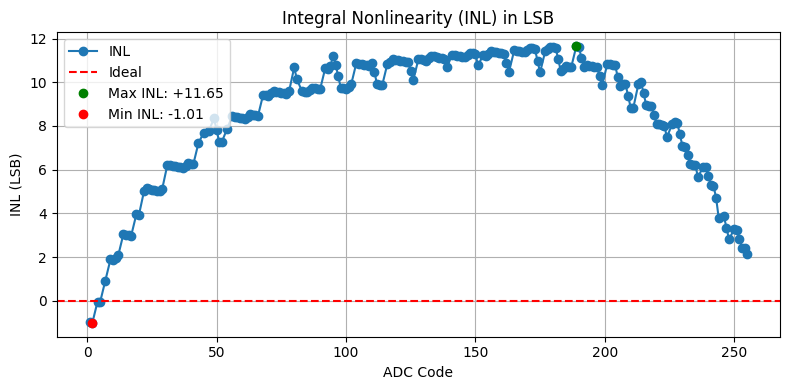

In [1620]:
# Calculate INL in volts
code_diffs = []
codes_used = []

y_adj_midpoints = np.array(y_adj_midpoints)
y_ideal_midpoints = np.array(y_ideal_midpoints)

# for each code step on the y axis, find the difference between the adjusted steps and the ideal steps in volts
# then convert to LSB
for code in range(256):
    adj_match = np.where(np.abs(y_adj_midpoints - code) < 0.5)[0]
    ideal_match = np.where(np.abs(y_ideal_midpoints - code) < 0.5)[0]

    if len(adj_match) > 0 and len(ideal_match) > 0:
        raw_v = x_adj_midpoints[adj_match[0]]
        ideal_v = x_ideal_midpoints[ideal_match[0]]
        code_diffs.append(((ideal_v - raw_v) * 256) - 1)  # Convert to LSB
        codes_used.append(code)


# removed these values because they were glitches
code_diffs.pop(66)
codes_used.pop(66)

inl_vals = np.array(code_diffs[0:len(codes_used)])
codes_used = np.array(codes_used)

# calculate max and min
max_inl = np.max(inl_vals)
min_inl = np.min(inl_vals)
pp_inl = max_inl - min_inl

# max and min indeces for plot
max_idx = np.argmax(inl_vals)
min_idx = np.argmin(inl_vals)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(codes_used, inl_vals, marker='o', linestyle='-', label='INL')
plt.axhline(0, color='red', linestyle='--', label='Ideal')

# Markers for max and min
plt.plot(codes_used[max_idx], max_inl, 'go', label=f'Max INL: +{max_inl:.2f}')
plt.plot(codes_used[min_idx], min_inl, 'ro', label=f'Min INL: {min_inl:.2f}')

# labels
plt.xlabel("ADC Code")
plt.ylabel("INL (LSB)")
plt.title("Integral Nonlinearity (INL) in LSB")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()

# Display summary
print(f"INL (Max): {max_inl:.4f} LSB at code {codes_used[max_idx]}")
print(f"INL (Min): {min_inl:.4f} LSB at code {codes_used[min_idx]}")
print(f"INL (Peak-to-Peak): {pp_inl:.2f} LSB")

plt.show()

In [1621]:
print(f"Offset Error: {offset_value_LSB:.2f} LSB")
print(f"Gain Error: {gain:.2f} LSB")
print(f"DNL: +{max_dnl:.2f}/+{min_dnl:.2f}")
print(f"INL: +{max_inl:.2f}/{min_inl:.2f}")


Offset Error: -2.86 LSB
Gain Error: 1.09 LSB
DNL: +2.82/+0.26
INL: +11.65/-1.01


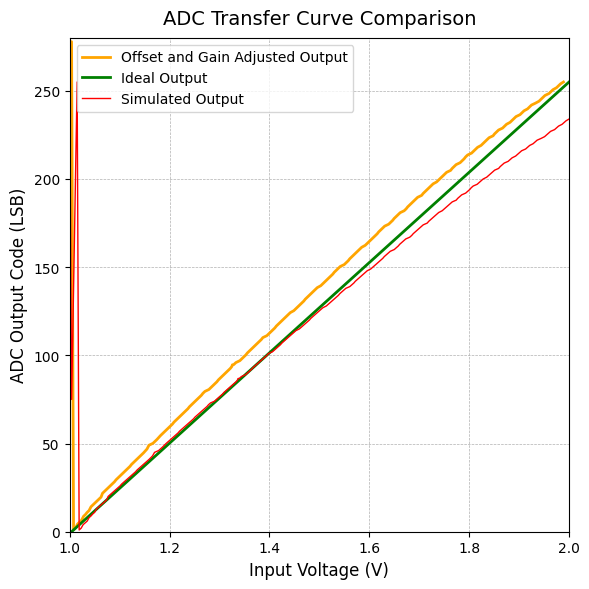

In [1622]:
plt.figure(figsize=(6, 6))

# Plot your data
plt.plot(x_adj_corners, y_adj_corners, label='Offset and Gain Adjusted Output', linewidth=2, color='orange')
plt.plot(x_ideal_corners, y_ideal_corners, label='Ideal Output', linewidth=2, color='green')
plt.plot(x_measured_corners, y_measured_corners, label='Simulated Output', linewidth=1, color='red')

# Add title and axis labels
plt.title('ADC Transfer Curve Comparison', fontsize=14, pad=10)
plt.xlabel('Input Voltage (V)', fontsize=12)
plt.ylabel('ADC Output Code (LSB)', fontsize=12)

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', fontsize=10)

# Set limits if needed
plt.xlim(1.0, 2.0)
plt.ylim(0, 280)

plt.tight_layout()
plt.show()